# Optimize denovo reference
    This script uses scripts provided by dDocent to de novo assembly in CD-HIT
    https://www.ddocent.com/assembly/
    
    Run dDocent first with basic commands. Use individuals retained from filtering to make assembly
    
## REDONE on 12/20/2022  

This is after most analyses. Want to be more strict about clustering simularity. Want to thoughtfully select individuals based off what is known

## For reference throughout this notebook:

**All unformatted text part of Trevor's original workflow.  Seth's annotations follow these rules**:  
+ *this text* = conceptual explanation of code<br>
+ <span style="color:purple">**this text**</span> = logical `code` explanation<br>
+ <span style="color:tomato">*this text*</span> = questions, uncertainties, parenthetical comments<br>
&nbsp;<br>

With that defined let's create a new section to talk about organization in this notebook...
<hr>
<hr>
    
## Sections:

1. Exploring file contents and formatting to run `RefOpt.sh`
2. Building slurm scripts to parallel run `RefOpt.sh`
3. Interpreting `RefOpt` output for determing optimal c parameter
4. Building slurm scripts to parallel run `MapOpt.sh`
5. Compare k parameters from `MapOpt` to create optimal assembly from full dataset

### 1.1 Import packages

In [1]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

*Just defining directory where we are working and checking with `pwd`*

In [5]:
root = "/data/gpfs/assoc/denovo/tfaske/SPCR/"

In [6]:
cd $root

/data/gpfs/assoc/denovo/tfaske/SPCR


In [7]:
pwd

'/data/gpfs/assoc/denovo/tfaske/SPCR'

### 1.2 Make assembly refopt dir and assign fastq dir

*directory itself is called 'assembly' while 'assembly_dir' is variable name presumably to avoid some variable/function confusion*

In [8]:
!mkdir assembly

In [9]:
!mkdir assembly/refOpt

In [10]:
assembly_dir = os.path.join(root,'assembly')

In [11]:
refOpt_dir = os.path.join(assembly_dir,'refOpt')

In [12]:
fq_dir = '/data/gpfs/assoc/denovo/tfaske/SPCR/fastq'

### 1.5 Sample random fastq for optimizer  

Use SPCR_keep_df from SPCR_manip, select individuals. Do it in R, easier for me.

Select 25 individuals. Only wild individuals and medium reads per population. Use SPCR_keep_df

*Idea here is to reduce the data we are initializing `RefOpt` and `MapOpt` on for efficiency purposes.  These test runs are just to determine optimal c, k1, and k2 parameters to build a final assembly for mapping.  Both scripts are huge alignment processes and would take way too long to run on full dataset.  Using 1 individual from eqach population with the most reads is a nice compromise. The final assembly will use **full** dataset.*

In [13]:
cd $root

/data/gpfs/assoc/denovo/tfaske/SPCR


In [14]:
%load_ext rpy2.ipython

In [27]:
%%R 

setwd('/data/gpfs/assoc/denovo/tfaske/SPCR/')

df <- read.csv('data/SPCR_data_all.csv')

dim(df)
head(df)
#print(table(paste0(pca_df$Variety,'_',pca_df$Color))

  species fq_ID                    site     date latitude longitude     name
1    SPCR    10             White Hills  8/20/20 34.69107 -111.8567  SPCR_10
2    SPCR    11             White Hills  8/20/20 34.69107 -111.8567  SPCR_11
3    SPCR    12             White Hills  8/20/20 34.69107 -111.8567  SPCR_12
4    SPCR    13                3 Rivers 10/10/20 33.32894 -105.9340  SPCR_13
5    SPCR    14                3 Rivers 10/10/20 33.32894 -105.9340  SPCR_14
6    SPCR   151 Water Canyon Campground  6/24/20 34.02405 -107.1340 SPCR_151
                 fq lane   reads      rename pop trmt ID        new_name
1  SPCR_10.r1.fq.gz   31 1195323  whitehills  WH    W  5  whitehills_W_5
2  SPCR_11.r1.fq.gz   31 1109916  whitehills  WH    W  6  whitehills_W_6
3  SPCR_12.r1.fq.gz   31 1519757  whitehills  WH    W  7  whitehills_W_7
4  SPCR_13.r1.fq.gz   31 1564485 threerivers  TR    W  1 threerivers_W_1
5  SPCR_14.r1.fq.gz   31 1561459 threerivers  TR    W  2 threerivers_W_2
6 SPCR_151.r1.fq.gz  L3

In [28]:
%%R
wild_df <- df[which(df$trmt == 'W'),]
length(unique(wild_df$pop))

[1] 37


In [29]:
%%R

#### randomly sample 22 populations and grab second more reads 
pops <- sample(as.character(unique(wild_df$pop)),22)
keep_fq <- c()
for (p in pops){
    pop_df <- wild_df[which(wild_df$pop == p),]
    pop_df2 <- pop_df[order(pop_df$reads,decreasing=TRUE),]
    #print(pop_df2)
    keep_fq <- c(keep_fq,pop_df2$new_fq[2])
}

length(keep_fq)
keep_fq

 [1] "whitehills_W_7.fq.gz"  "alamosa_W_5.fq.gz"     "kennedy_W_4.fq.gz"    
 [4] "caballo_W_2.fq.gz"     "cieneguilla_W_2.fq.gz" "santafe_W_4.fq.gz"    
 [7] "blm_W_2.fq.gz"         "stanton_W_7.fq.gz"     "petroglyph_W_8.fq.gz" 
[10] "queen_W_1.fq.gz"       "bonanza_W_1.fq.gz"     "threerivers_W_3.fq.gz"
[13] "buckman2_W_10.fq.gz"   "camino_W_2.fq.gz"      "tierra_W_6.fq.gz"     
[16] "cerrillos_W_6.fq.gz"   "horsemtn_W_3.fq.gz"    "dell_W_9.fq.gz"       
[19] "aguirre_W_9.fq.gz"     "sandias_W_2.fq.gz"     "taos_W_4.fq.gz"       
[22] "young_W_2.fq.gz"      


In [31]:
%%R
#keep_fq
### mv keep_fq to refOpt

fq_dir <- '/data/gpfs/assoc/denovo/tfaske/SPCR/fastq/'
refOpt_dir <- '/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/refOpt/'

#cp_cmd <- array(NA,dim=length(keep_fq))
for (i in 1:length(keep_fq)){
    #cp_cmd[i] <- paste0('cp ',fq_dir,keep_fq[i],'.F.fq.gz ',refOpt_dir)
    cmd <- paste0('cp ',fq_dir,keep_fq[i],' ',refOpt_dir)
    system(cmd)
}
#cp_cmd

In [32]:
!ls {refOpt_dir}/*gz | wc -l 

22


# 2. Make a slurm script to run ReferenceOpt.sh   

ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors  
    
#### NOTE: must run dDocent to at least trim first 

### Understanding ReferenceOpt.sh (in process of transferring notes)

Much of the details can't be found here: http://www.ddocent.com/assembly/<br>
This script is written by Jon Puritz to determine what c parameter is optimal for reference assembly.  The steps below are repeatedly iteratively with all c values 0.80-0.98 and 0.02 increments.  Each of these c parameters are also run with each combination of k1 and k2 parameters based on a set min-max range (here we use 4-10 for both).  k1 indicates the minimum number of times a contig must occur *within* an inidividual to be used in clustering while k2 indicates minimum number of individuals a contig must occur in to be included.  c parameter used to set cluster similarity threshold.  Output is designed to identify point of inflection where data is goes from reliable to erroneous.  k parameter ranges simply used to ensure that interpretation of inflection point isn't biased by k pairing. The workflow generally follows:  
+ Read trimming
+ Initial clustering with low similarity via `CD-HIT`
    + Original script may have called for 80% which is very loose but is intended to do initial rough grouping to reduce downstream complexity.  <span style="color:tomato">Need to check this script as it may have been modified by Trevor to use different parameters at clustering steps</span>
+ Clustering with `rainbow`
+ Mapping of forward reads with `bwa`
    + If using paired-end reads, adds additional step to compare clustering of `CD-HIT` with reverse reads.  If clustered accurately, clustering of reverse and forward reads should agree

In [33]:
refOpt = '/data/gpfs/assoc/denovo/src/refOpt/./ReferenceOpt.sh'
refOpt_dir = os.path.join(assembly_dir,'refOpt')

In [34]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/refOpt


In [35]:
### select options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
jobname = 'SPCR_refOpt'
time = '4-00:00:00' #time limit 4 days
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 
cpus = 64
mem_cpu = 2500
email = 'tfaske@nevada.unr.edu'

In [36]:
def write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type):
    with open("run_refOpt.sh", "w") as o:
        o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name %s
#SBATCH --output output_refOpt.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,int(cpus),int(mem_cpu),jobname,email))

        #ReferenceOpt.sh minK1 maxK1 minK2 maxK2 Assembly_Type Processors
        o.write("%s %d %d %d %d %s %d" % (refOpt,minK1,maxK1,minK2,maxK2,Type,cpus))

In [37]:
write_refOpt_sh(account,partition,cpus,mem_cpu,email,refOpt,minK1,maxK1,minK2,maxK2,Type)

# run refOpt.sh in slurm
    cd /data/gpfs/assoc/denovo/ERNA/assembly/refOpt
    source activate ddocent_env
    sbatch run_refOpt.sh

# Visualize kopt from refOpt

In [38]:
cd $refOpt_dir

/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/refOpt


In [39]:
!tail output_refOpt.txt

The top three most common number of contigs
X	Contig number
2	26840
2	18231
1	9845
The top three most common number of contigs (with values rounded)
X	Contig number
6	21800
5	29100
4	27700


In [40]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython



── Column specification ────────────────────────────────────────────────────────
cols(
  k1 = col_double(),
  k2 = col_double(),
  c = col_double(),
  contig = col_double()
)



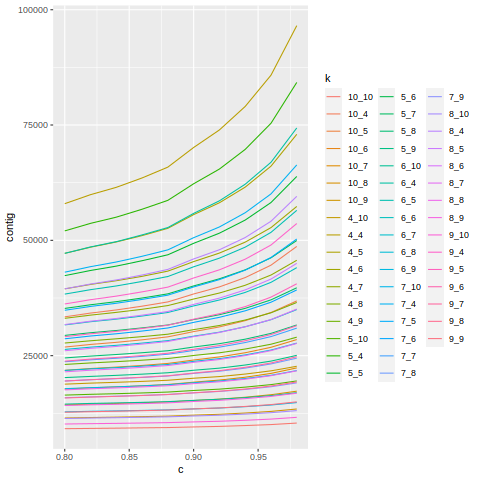

In [41]:
%%R
library(readr)
library(ggplot2)

kopt <- read_table2('kopt.data',col_names = c('k1','k2','c','contig'))
kopt$k <- paste0(kopt$k1,'_',kopt$k2)

ggplot(data=kopt,aes(x=c,y=contig,colour=k)) + 
  geom_line() 

c = .88, .92, .96 is the winner!, look where it starts to tick up

# MapOpt now!!!
    This script assembles references across cutoff values and then maps 20 random samples and evaluates mappings to the reference, along with number of contigs and coverage.
    
    Moves fastq files from refOpt, runs dDocent to get trimmed files
    
    choose mapOpt sim from kopt above: 94 add (e.g. 92,94,96)

In [42]:
cd $assembly_dir

/data/gpfs/assoc/denovo/tfaske/SPCR/assembly


In [43]:
!mkdir mapOpt

In [44]:
mapOpt_dir = os.path.join(assembly_dir,'mapOpt')
assert mapOpt_dir

In [45]:
sim_val = [88,92,96]

In [46]:
for sim in sim_val:
    mapsim = "mapOpt/mapOpt%d" % (sim)
    !mkdir $mapsim

In [47]:
### cp fastq from refOpt
fq_files = !find $refOpt_dir -name '*fq.gz'
fq_files = [os.path.abspath(x) for x in fq_files]
len(fq_files),fq_files[0]

(44,
 '/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/refOpt/buckman2_W_10.F.fq.gz')

In [48]:
for fq in fq_files:   
    for sim in sim_val:
        mapsim = "mapOpt/mapOpt%d" % (sim)
        !cp $fq $mapsim

In [49]:
for sim in sim_val:
    mapsim = "mapOpt/mapOpt%d" % (sim)
    logfiles = os.path.join(refOpt_dir,'logfiles')
    !cp -r $logfiles $mapsim

In [50]:
src_dir = '/data/gpfs/assoc/denovo/src/refOpt/./'
mapOpt_sh = []
for sim in sim_val:
    sh = src_dir + "Map%d.sh"%(sim)
    mapOpt_sh.append(sh)

In [51]:
len(mapOpt_sh), mapOpt_sh

(3,
 ['/data/gpfs/assoc/denovo/src/refOpt/./Map88.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map92.sh',
  '/data/gpfs/assoc/denovo/src/refOpt/./Map96.sh'])

In [52]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 1 days
cpus = 16
mem_cpu = 9000

#RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
minK1 = 4
maxK1 = 10
minK2 = 4
maxK2 = 10
Type = 'SE' 

In [53]:
cd $mapOpt_dir

/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/mapOpt


In [54]:
def write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,mapOpt_dir,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type):
    for i in range(0,len(mapOpt_sh)):
        sh = mapOpt_sh[i]
        sim = sim_val[i]
        with open("mapOpt%d/run_mapOpt%d.sh" % (sim,sim), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name mapOpt%d
#SBATCH --output output_mapOpt%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

cd %s/mapOpt%d\n\n""" % (account,partition,time,int(cpus),int(mem_cpu),sim,sim,email,mapOpt_dir,sim))

        #RefMapOpt minK1 maxK1 minK2 maxK2 cluster_similarity Assembly_Type Num_of_Processors
            o.write("""%s %d %d %d %d 0.%d %s %d"""% (sh,minK1,maxK1,minK2,maxK2,sim,Type,cpus))

In [55]:
write_mapOpt_sh(account,partition,time,cpus,mem_cpu,sim,email,mapOpt_dir,
                    mapOpt_sh,sim_val,minK1,maxK1,minK2,maxK2,Type)

In [56]:
mapShells = !find $mapOpt_dir -name 'run_map*.sh'
mapShells

['/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/mapOpt/mapOpt96/run_mapOpt96.sh',
 '/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/mapOpt/mapOpt92/run_mapOpt92.sh',
 '/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/mapOpt/mapOpt88/run_mapOpt88.sh']

In [83]:
def write_sbatch_mapOpt(mapShells):
         with open("sbatch_mapOpt.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in mapShells:
                o.write("""sbatch %s\n""" % (sh))

In [84]:
write_sbatch_mapOpt(mapShells)

# Run all mapOpt*sh ()
    cd /data/gpfs/assoc/denovo/PHHA/assembly/mapOpt
    source activate ddocent_env
    bash sbatch_mapOpt.sh

# Read in mapping results and make decision

In [57]:
cd $root

/data/gpfs/assoc/denovo/tfaske/SPCR


In [58]:
mapResults = !find . -name 'mapping*results'
mapResults

['./assembly/mapOpt/mapOpt96/mapping96.results',
 './assembly/mapOpt/mapOpt92/mapping92.results',
 './assembly/mapOpt/mapOpt88/mapping88.results']

In [59]:
for mR in mapResults:
    print(mR)
    !cat $mR
    print('\n')

./assembly/mapOpt/mapOpt96/mapping96.results
Cov	Non0Cov	Contigs	MeanContigsMapped	K1	K2	SUM Mapped	SUM Properly	Mean Mapped	Mean Properly	MisMatched
18.1176	29.4848	85804	56829.1	4	4	24873279	0	1.55458e+06	0	0
22.4459	33.0484	66083	47656.1	4	5	23733049	0	1.48332e+06	0	0
26.7913	36.7378	52759	40424.5	4	6	22616118	0	1.41351e+06	0	0
31.5302	40.8666	42478	34123.6	4	7	21429935	0	1.33937e+06	0	0
36.7612	45.4635	34288	28640.6	4	8	20168057	0	1.2605e+06	0	0
42.7189	50.7722	27476	23723.7	4	9	18780609	0	1.17379e+06	0	0
49.6699	57.0958	21707	19271.2	4	10	17251742	0	1.07823e+06	0	0
20.1948	31.5563	75378	51520.7	5	4	24356196	0	1.52226e+06	0	0
24.8691	35.4569	58198	43031.7	5	5	23157675	0	1.44735e+06	0	0
29.7404	39.6711	46214	36177.4	5	6	21991283	0	1.37446e+06	0	0
34.9174	44.1773	37096	30369.4	5	7	20725276	0	1.29533e+06	0	0
40.6329	49.2846	29828	25287.6	5	8	19392627	0	1.21204e+06	0	0
47.2068	55.2467	23817	20815.6	5	9	17989952	0	1124372	0	0
54.7739	62.1367	18721	16796.7	5	10	16407632	0	1025477	0	0
22.

In [60]:
%%R 
library(readr)
library(data.table)
setwd('/data/gpfs/assoc/denovo/tfaske/SPCR/assembly/mapOpt')


mapping88 <- read_table2('mapOpt88/mapping88.results')
mapping88$k <- paste0(mapping88$K1,'_',mapping88$K2)
mapping88$sim <- '88'
mapping88$ratio <- abs( scale(mapping88$SUM_1) / (scale(mapping88$MeanContigsMapped) / scale(mapping88$Cov) ) ) 

mapping92 <- read_table2('mapOpt92/mapping92.results')
mapping92$k <- paste0(mapping92$K1,'_',mapping92$K2)
mapping92$sim <- '92'
mapping92$ratio <- abs( scale(mapping92$SUM_1) / (scale(mapping92$MeanContigsMapped) / scale(mapping92$Cov) ) ) 

mapping96 <- read_table2('mapOpt96/mapping96.results')
mapping96$k <- paste0(mapping96$K1,'_',mapping96$K2)
mapping96$sim <- '96'
mapping96$ratio <- abs( scale(mapping96$SUM_1) / (scale(mapping96$MeanContigsMapped) / scale(mapping96$Cov) ) )

#print(mapping92)
#print(mapping88)
#print(mapping96)

#map_df
map_df <- rbindlist(list(mapping88,mapping92,mapping96))
head(map_df)

R[write to console]: data.table 1.14.6 using 32 threads (see ?getDTthreads).  Latest news: r-datatable.com




── Column specification ────────────────────────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)



R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt88/mapping88.results'
  2  -- 15 columns 11 columns 'mapOpt88/mapping88.results'
  3  -- 15 columns 11 columns 'mapOpt88/mapping88.results'
  4  -- 15 columns 11 columns 'mapOpt88/mapping88.results'
  5  -- 15 columns 11 columns 'mapOpt88/mapping88.results'
... ... .......... .......... ............................
See problems(...) for more details.





── Column specification ────────────────────────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)



R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  2  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  3  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  4  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
  5  -- 15 columns 11 columns 'mapOpt92/mapping92.results'
... ... .......... .......... ............................
See problems(...) for more details.





── Column specification ────────────────────────────────────────────────────────
cols(
  Cov = col_double(),
  Non0Cov = col_double(),
  Contigs = col_double(),
  MeanContigsMapped = col_double(),
  K1 = col_double(),
  K2 = col_double(),
  SUM = col_double(),
  Mapped = col_double(),
  SUM_1 = col_double(),
  Properly = col_double(),
  Mean = col_double(),
  Mapped_1 = col_character(),
  Mean_1 = col_character(),
  Properly_1 = col_character(),
  MisMatched = col_character()
)



R[write to console]: Warning:
R[write to console]:  49 parsing failures.
row col   expected     actual                         file
  1  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  2  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  3  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  4  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
  5  -- 15 columns 11 columns 'mapOpt96/mapping96.results'
... ... .......... .......... ............................
See problems(...) for more details.




       Cov Non0Cov Contigs MeanContigsMapped K1 K2      SUM Mapped   SUM_1
1: 23.7452 36.2230   65876           45972.8  4  4 25028203      0 1564260
2: 28.3409 39.9882   52610           39278.0  4  5 23856710      0 1491040
3: 32.7863 43.7702   43329           33941.1  4  6 22730090      0 1420630
4: 37.5141 47.9125   35859           29168.3  4  7 21524062      0 1345250
5: 42.6913 52.5258   29651           24887.7  4  8 20254115      0 1265880
6: 48.3869 57.7014   24379           21007.6  4  9 18874762      0 1179670
   Properly Mean Mapped_1 Mean_1 Properly_1 MisMatched   k sim      ratio
1:        0    0     <NA>   <NA>       <NA>       <NA> 4_4  88 1.19910400
2:        0    0     <NA>   <NA>       <NA>       <NA> 4_5  88 1.09923131
3:        0    0     <NA>   <NA>       <NA>       <NA> 4_6  88 0.96294385
4:        0    0     <NA>   <NA>       <NA>       <NA> 4_7  88 0.77719336
5:        0    0     <NA>   <NA>       <NA>       <NA> 4_8  88 0.56848722
6:        0    0     <NA>   <NA

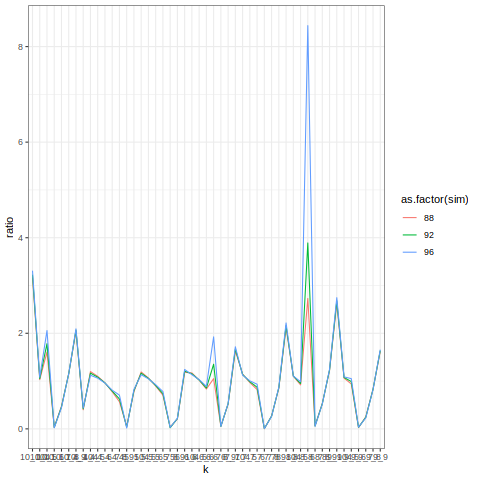

In [61]:
%%R
ggplot(data=map_df,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [63]:
%%R 
colMeans(map_df[,c(1:7,9)])

              Cov           Non0Cov           Contigs MeanContigsMapped 
     4.648880e+01      5.660185e+01      3.097990e+04      2.473056e+04 
               K1                K2               SUM             SUM_1 
     7.000000e+00      7.000000e+00      1.980902e+07      1.212711e+06 


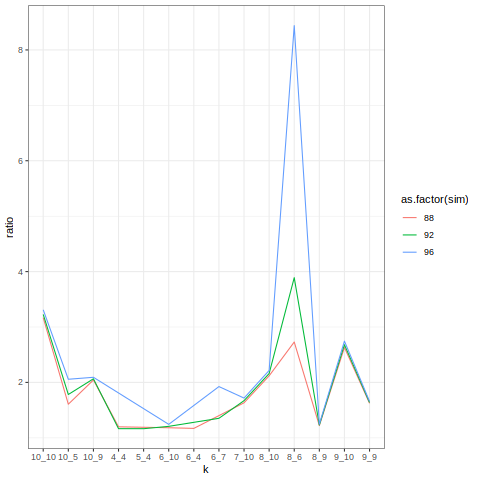

In [62]:
%%R
map_top <- map_df[which(map_df$ratio > quantile(map_df$ratio,probs=.75)),]

#SUM Properly
ggplot(data=map_top,aes(x=k,y=ratio,color=as.factor(sim))) + 
    geom_line(aes(group=as.factor(sim))) + theme_bw()

In [64]:
%%R
names(map_df)

 [1] "Cov"               "Non0Cov"           "Contigs"          
 [4] "MeanContigsMapped" "K1"                "K2"               
 [7] "SUM"               "Mapped"            "SUM_1"            
[10] "Properly"          "Mean"              "Mapped_1"         
[13] "Mean_1"            "Properly_1"        "MisMatched"       
[16] "k"                 "sim"               "ratio"            


In [65]:
%%R
map_df[which(map_df$k %in% c('8_6')),c(1:7,9,17,18)]

       Cov Non0Cov Contigs MeanContigsMapped K1 K2      SUM   SUM_1 sim
1: 44.8747 55.8777   28076           23230.6  8  6 20159171 1259950  88
2: 42.0962 53.0463   30029           24610.5  8  6 21490558 1264150  92
3: 38.2539 48.1435   32825           26889.1  8  6 20091540 1255720  96
      ratio
1: 2.729166
2: 3.890261
3: 8.438276


# Map results 
    sim=96 K1=8 k2=6 WINNER
    
    remake reference in fastq using these parameters. Move reference.fasta to assembly dir